## Horses or Humans using Transfer Learning using Inception V3

In [1]:
import tensorflow as tf
from tensorflow import keras

ACCRUACY_THRESHOLD = 0.999

class myCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        if (logs['accuracy']) > ACCRUACY_THRESHOLD:
            print ("\nReached desired accuracy. Stops training")
            self.model.stop_training = True

In [2]:
import os
import zipfile

train_folder         = 'C:/VIN_PYCHARM/ONE/Data/temp/horse-or-human'
validation_folder    = 'C:/VIN_PYCHARM/ONE/Data/temp/validation-horse-or-human'

zipfilename  = 'C:/VIN_PYCHARM/ONE/Data/horse-or-human.zip'
zipref = zipfile.ZipFile(zipfilename, 'r')
zipref.extractall(train_folder)


zipfilename = 'C:/VIN_PYCHARM/ONE/Data/validation-horse-or-human.zip'
zipref = zipfile.ZipFile(zipfilename, 'r')
zipref.extractall(validation_folder)

In [3]:
from tensorflow.keras import layers
from tensorflow.keras import Model
from tensorflow.keras.applications.inception_v3 import InceptionV3

local_weights_file='C:/VIN_PYCHARM/ONE/Data/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5'

pre_trained_model = InceptionV3(input_shape=(150,150,3),
                                include_top=False,
                                weights=None)
pre_trained_model.load_weights(local_weights_file)

for layer in pre_trained_model.layers:
    layer.trainable = False

pre_trained_model.summary()



Model: "inception_v3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 150, 150, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 74, 74, 32)   864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 74, 74, 32)   96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 74, 74, 32)   0           batch_normalization[0][0]        
_______________________________________________________________________________________

In [4]:
last_layer = pre_trained_model.get_layer('mixed7')
last_output = last_layer.output

In [5]:
x = layers.Flatten()(last_output)
x = layers.Dense(1024, activation='relu')(x)
x = layers.Dropout(0.2)(x)
x = layers.Dense(1, activation='sigmoid')(x)

model = Model(pre_trained_model.input, x)


In [6]:
from tensorflow.keras.optimizers import RMSprop

model.compile(optimizer=RMSprop(lr=0.0001), loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 150, 150, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 74, 74, 32)   864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 74, 74, 32)   96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 74, 74, 32)   0           batch_normalization[0][0]        
______________________________________________________________________________________________

In [7]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(rescale=1/255,
                                   rotation_range=40,
                                   width_shift_range=0.2,
                                   height_shift_range=0.2,
                                   shear_range=0.2,
                                   zoom_range=0.2,
                                   horizontal_flip=True)
validation_datagen = ImageDataGenerator(rescale=1/255)

train_generator = train_datagen.flow_from_directory(train_folder,
                                                    target_size =(150,150),
                                                    batch_size =128,
                                                    class_mode ='binary')

validattion_generator = validation_datagen.flow_from_directory(validation_folder,
                                                               target_size =(150,150),
                                                               batch_size =32,
                                                               class_mode ='binary')


Found 1027 images belonging to 2 classes.
Found 256 images belonging to 2 classes.


In [8]:
callbacks = myCallback()
history = model.fit(train_generator,
                    epochs=3,
                    verbose = 1,
                    validation_data=validattion_generator,
                    callbacks=[callbacks])



Epoch 1/3
9/9 [==============================] - 28s 3s/step - loss: 0.6600 - accuracy: 0.8072 - val_loss: 0.0577 - val_accuracy: 1.0000
Epoch 2/3
9/9 [==============================] - 28s 3s/step - loss: 0.0681 - accuracy: 0.9786 - val_loss: 0.0214 - val_accuracy: 0.9922

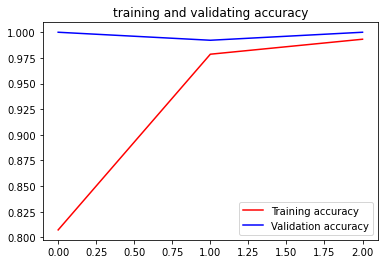

<Figure size 432x288 with 0 Axes>

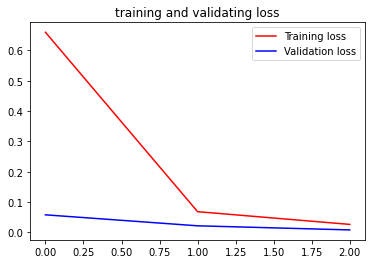

In [9]:
import matplotlib.pyplot as plt
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label = 'Training accuracy')
plt.plot(epochs, val_acc, 'b', label = 'Validation accuracy')
plt.title('training and validating accuracy')
plt.legend(loc=0)
plt.figure()
plt.show()

plt.plot(epochs, loss, 'r', label = 'Training loss')
plt.plot(epochs, val_loss, 'b', label = 'Validation loss')
plt.title('training and validating loss')
plt.legend(loc=0)


In [11]:
from keras_preprocessing import image


image_path = 'C:/VIN_PYCHARM/ONE/Data/test/horse.jpg'
test_img_temp = image.load_img(image_path, target_size=(150,150))
test_img = image.img_to_array(test_img_temp)
test_img = test_img.reshape((1,) + test_img.shape)
test_img/= 255

classes = model.predict(test_img, batch_size=8)

print(classes[0])
if classes[0]>0.5:
    print("human")
else:
    print("horse")


[1.996272e-09]
horse
